In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
# Path to your dataset
data_path = '/content/drive/MyDrive/ELEG605/ELEG605/prj/highly_balanced_traffic_data_binary.csv'

# Function to process data in chunks
def process_chunks(file_path, chunksize=100000, subset_frac=0.1):
    sampled_chunks = []
    total_rows = 0
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        # Count total rows
        total_rows += len(chunk)
        # Stratified sampling on the chunk
        stratified_chunk = chunk.groupby('target', group_keys=False).apply(
            lambda x: x.sample(frac=subset_frac, random_state=42)
        )
        sampled_chunks.append(stratified_chunk)

    # Combine sampled chunks
    sampled_data = pd.concat(sampled_chunks, ignore_index=True)
    print(f"Processed {total_rows} rows. Sampled down to {len(sampled_data)} rows.")
    return sampled_data

# Load and subset the dataset
subset_df = process_chunks(data_path, chunksize=100000, subset_frac=0.2)

# Prepare data
X = subset_df.drop(columns=['target'])
y = subset_df['target']


<ipython-input-6-8f06e6dc1bfe>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_chunk = chunk.groupby('target', group_keys=False).apply(
<ipython-input-6-8f06e6dc1bfe>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_chunk = chunk.groupby('target', group_keys=False).apply(
<ipython-input-6-8f06e6dc1bfe>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. 

Processed 1999204 rows. Sampled down to 399841 rows.


In [7]:
print(f"X.shape", X.shape)
print(f"y.shape", y.shape)

X.shape (399841, 124)
y.shape (399841,)


In [8]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [10]:

base_models = [
    # Logistic Regression with L2 regularization (ridge regression)
    ('lr', LogisticRegression(penalty='l2', C=10.0, max_iter=20, random_state=42)),

    # Decision Tree with reduced depth and min_samples_split to avoid overfitting
    ('dt', DecisionTreeClassifier(max_depth=8, min_samples_split=10, random_state=42)),

    # Random Forest with regularization via max_depth and min_samples_leaf
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_leaf=5, random_state=42))
]

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle
import random

In [23]:

# K-Fold Cross Validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
meta_train_list, meta_test_list, y_train_list, y_test_list = [], [], [], []

# Function to corrupt predictions with random corruption rates
def corrupt_predictions(y_pred, min_rate=0.3, max_rate=0.5):
    corruption_rate = random.uniform(min_rate, max_rate)  # Randomly select a corruption rate
    corrupted = y_pred.copy()
    for i in range(len(corrupted)):
        if random.random() < corruption_rate:
            corrupted[i] = 1 - corrupted[i]  # Flip binary prediction
    return corrupted, corruption_rate

# Train base models and collect probabilities for meta-learning
for fold, (train_index, test_index) in enumerate(kf.split(X_scaled)):
    print(f"=== Fold {fold + 1} ===")
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    meta_train = np.zeros((X_train.shape[0], len(base_models) * 2))  # 2 classes for binary classification
    meta_test = np.zeros((X_test.shape[0], len(base_models) * 2))

    # Train base models and collect predictions
    for i, (name, model) in enumerate(base_models):
        print(f"Training {name} model on fold {fold + 1}...")
        model.fit(X_train, y_train)

        # Predictions before corruption
        y_pred_proba_train = model.predict_proba(X_train)
        y_pred_proba_test = model.predict_proba(X_test)

        # Store probabilities in meta data
        meta_train[:, i*2:(i+1)*2] = y_pred_proba_train
        meta_test[:, i*2:(i+1)*2] = y_pred_proba_test

        # Print Classification Report Before Corruption
        y_pred_test = model.predict(X_test)
        print(f"Classification Report for {name} on Test Data (before corruption):")
        print(classification_report(y_test, y_pred_test))

        # Corrupt predictions
        y_pred_test_corrupted, corruption_rate = corrupt_predictions(model.predict(X_test))
        print(f"Corruption Rate for {name}: {corruption_rate:.2%}")
        print(f"Classification Report for {name} on Test Data (after corruption):")
        print(classification_report(y_test, y_pred_test_corrupted))


=== Fold 1 ===
Training lr model on fold 1...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for lr on Test Data (before corruption):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66591
           1       1.00      1.00      1.00     66690

    accuracy                           1.00    133281
   macro avg       1.00      1.00      1.00    133281
weighted avg       1.00      1.00      1.00    133281

Corruption Rate for lr: 36.56%
Classification Report for lr on Test Data (after corruption):
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     66591
           1       0.63      0.64      0.64     66690

    accuracy                           0.63    133281
   macro avg       0.63      0.63      0.63    133281
weighted avg       0.63      0.63      0.63    133281

Training dt model on fold 1...
Classification Report for dt on Test Data (before corruption):
              precision    recall  f1-score   support

           0       1.00      1.00      1.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for lr on Test Data (before corruption):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66495
           1       1.00      1.00      1.00     66785

    accuracy                           1.00    133280
   macro avg       1.00      1.00      1.00    133280
weighted avg       1.00      1.00      1.00    133280

Corruption Rate for lr: 45.37%
Classification Report for lr on Test Data (after corruption):
              precision    recall  f1-score   support

           0       0.55      0.55      0.55     66495
           1       0.55      0.55      0.55     66785

    accuracy                           0.55    133280
   macro avg       0.55      0.55      0.55    133280
weighted avg       0.55      0.55      0.55    133280

Training dt model on fold 2...
Classification Report for dt on Test Data (before corruption):
              precision    recall  f1-score   support

           0       1.00      1.00      1.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for lr on Test Data (before corruption):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66835
           1       1.00      1.00      1.00     66445

    accuracy                           1.00    133280
   macro avg       1.00      1.00      1.00    133280
weighted avg       1.00      1.00      1.00    133280

Corruption Rate for lr: 35.82%
Classification Report for lr on Test Data (after corruption):
              precision    recall  f1-score   support

           0       0.64      0.64      0.64     66835
           1       0.64      0.64      0.64     66445

    accuracy                           0.64    133280
   macro avg       0.64      0.64      0.64    133280
weighted avg       0.64      0.64      0.64    133280

Training dt model on fold 3...
Classification Report for dt on Test Data (before corruption):
              precision    recall  f1-score   support

           0       1.00      1.00      1.

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Train base models and collect probabilities for meta-learning
for fold, (train_index, test_index) in enumerate(kf.split(X_scaled)):
    print(f"=== Fold {fold + 1} ===")
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    meta_train = np.zeros((X_train.shape[0], len(base_models) * 2))  # 2 classes for binary classification
    meta_test = np.zeros((X_test.shape[0], len(base_models) * 2))

    # Train base models and collect predictions
    for i, (name, model) in enumerate(base_models):
        print(f"Training {name} model on fold {fold + 1}...")
        model.fit(X_train, y_train)

        # Predictions before corruption
        y_pred_proba_train = model.predict_proba(X_train)
        y_pred_proba_test = model.predict_proba(X_test)

        # Store probabilities in meta data
        meta_train[:, i*2:(i+1)*2] = y_pred_proba_train
        meta_test[:, i*2:(i+1)*2] = y_pred_proba_test

        # Print Classification Report Before Corruption
        y_pred_test = model.predict(X_test)
        print(f"Classification Report for {name} on Test Data (before corruption):")
        print(classification_report(y_test, y_pred_test))

        # Corrupt predictions
        y_pred_test_corrupted, corruption_rate = corrupt_predictions(model.predict(X_test))
        print(f"Corruption Rate for {name}: {corruption_rate:.2%}")
        print(f"Classification Report for {name} on Test Data (after corruption):")
        print(classification_report(y_test, y_pred_test_corrupted))

    meta_train_list.append(meta_train)
    meta_test_list.append(meta_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

# Combine meta features and labels
meta_train_combined = np.vstack(meta_train_list)
meta_test_combined = np.vstack(meta_test_list)
y_train_combined = np.concatenate(y_train_list)
y_test_combined = np.concatenate(y_test_list)

# Define MLP Meta-Learner
class MLPMetaLearner(nn.Module):
    def __init__(self, input_size):
        super(MLPMetaLearner, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=1)

# Convert meta features to tensors
X_train_tensor = torch.tensor(meta_train_combined, dtype=torch.float32)
X_test_tensor = torch.tensor(meta_test_combined, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_combined, dtype=torch.long)

# Train the MLP meta-learner
mlp_meta_learner = MLPMetaLearner(input_size=meta_train_combined.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_meta_learner.parameters(), lr=0.001)

# Train the MLP meta-learner
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mlp_meta_learner(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the MLP meta-learner
mlp_meta_learner.eval()
with torch.no_grad():
    y_pred_test = mlp_meta_learner(X_test_tensor.to(device))
    y_pred_test_class = torch.argmax(y_pred_test, dim=1).cpu().numpy()

# Print classification report for the meta-learner
print("\nMLP Meta-Learner Performance:")
print(classification_report(y_test_combined, y_pred_test_class))

Using device: cuda
=== Fold 1 ===
Training lr model on fold 1...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for lr on Test Data (before corruption):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66591
           1       1.00      1.00      1.00     66690

    accuracy                           1.00    133281
   macro avg       1.00      1.00      1.00    133281
weighted avg       1.00      1.00      1.00    133281

Corruption Rate for lr: 41.64%
Classification Report for lr on Test Data (after corruption):
              precision    recall  f1-score   support

           0       0.58      0.58      0.58     66591
           1       0.58      0.58      0.58     66690

    accuracy                           0.58    133281
   macro avg       0.58      0.58      0.58    133281
weighted avg       0.58      0.58      0.58    133281

Training dt model on fold 1...
Classification Report for dt on Test Data (before corruption):
              precision    recall  f1-score   support

           0       1.00      1.00      1.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for lr on Test Data (before corruption):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66495
           1       1.00      1.00      1.00     66785

    accuracy                           1.00    133280
   macro avg       1.00      1.00      1.00    133280
weighted avg       1.00      1.00      1.00    133280

Corruption Rate for lr: 36.61%
Classification Report for lr on Test Data (after corruption):
              precision    recall  f1-score   support

           0       0.63      0.64      0.63     66495
           1       0.64      0.63      0.64     66785

    accuracy                           0.64    133280
   macro avg       0.64      0.64      0.64    133280
weighted avg       0.64      0.64      0.64    133280

Training dt model on fold 2...
Classification Report for dt on Test Data (before corruption):
              precision    recall  f1-score   support

           0       1.00      1.00      1.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for lr on Test Data (before corruption):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66835
           1       1.00      1.00      1.00     66445

    accuracy                           1.00    133280
   macro avg       1.00      1.00      1.00    133280
weighted avg       1.00      1.00      1.00    133280

Corruption Rate for lr: 47.79%
Classification Report for lr on Test Data (after corruption):
              precision    recall  f1-score   support

           0       0.52      0.52      0.52     66835
           1       0.52      0.52      0.52     66445

    accuracy                           0.52    133280
   macro avg       0.52      0.52      0.52    133280
weighted avg       0.52      0.52      0.52    133280

Training dt model on fold 3...
Classification Report for dt on Test Data (before corruption):
              precision    recall  f1-score   support

           0       1.00      1.00      1.

--------------------------------------------------------------------
End coding

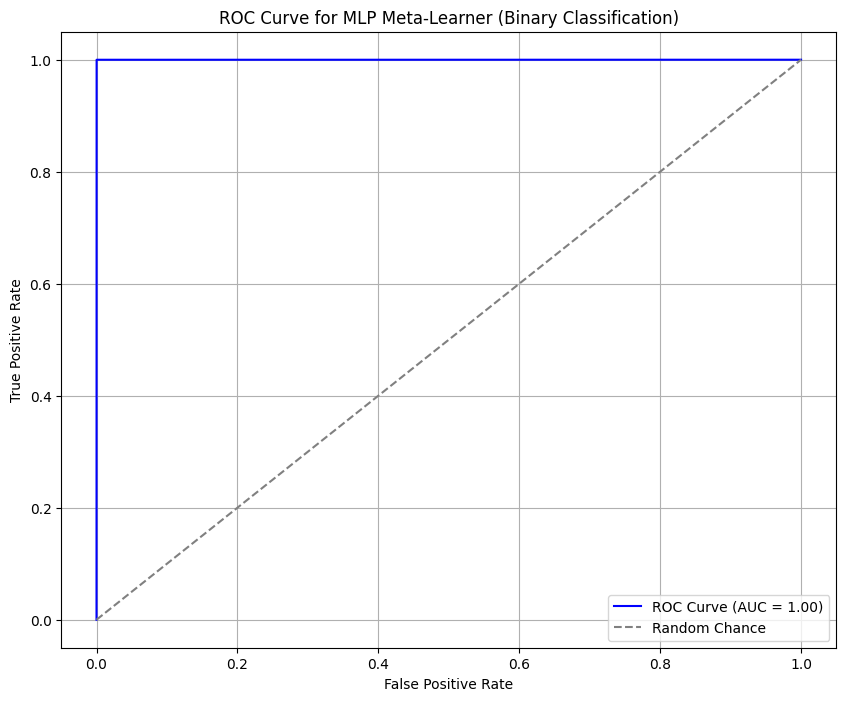

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize test labels for ROC calculation (binary classification)
y_test_binarized = label_binarize(y_test_combined, classes=[0, 1])

# Calculate probabilities from the MLP meta-learner
y_pred_probabilities = y_pred_test.cpu().numpy()

# Ensure the probabilities match the correct dimension for binary classification
if y_pred_probabilities.shape[1] == 2:  # Check for binary classification
    y_pred_prob_class_1 = y_pred_probabilities[:, 1]  # Probabilities for class 1
else:
    raise ValueError("Predicted probabilities dimension is incorrect.")

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_prob_class_1)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance')
plt.title('ROC Curve for MLP Meta-Learner (Binary Classification)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()
plt.savefig('roc_curve.pdf')


In [27]:
print("Shape of y_test_binarized:", y_test_binarized.shape)
print("Shape of y_pred_probabilities:", y_pred_probabilities.shape)


Shape of y_test_binarized: (399841, 1)
Shape of y_pred_probabilities: (399841, 2)


In [28]:
print("Predicted probabilities:", y_pred_probabilities[:5])


Predicted probabilities: [[0.94800746 0.05199258]
 [0.94800764 0.05199234]
 [0.94800746 0.05199249]
 [0.94800425 0.05199576]
 [0.94800663 0.05199336]]


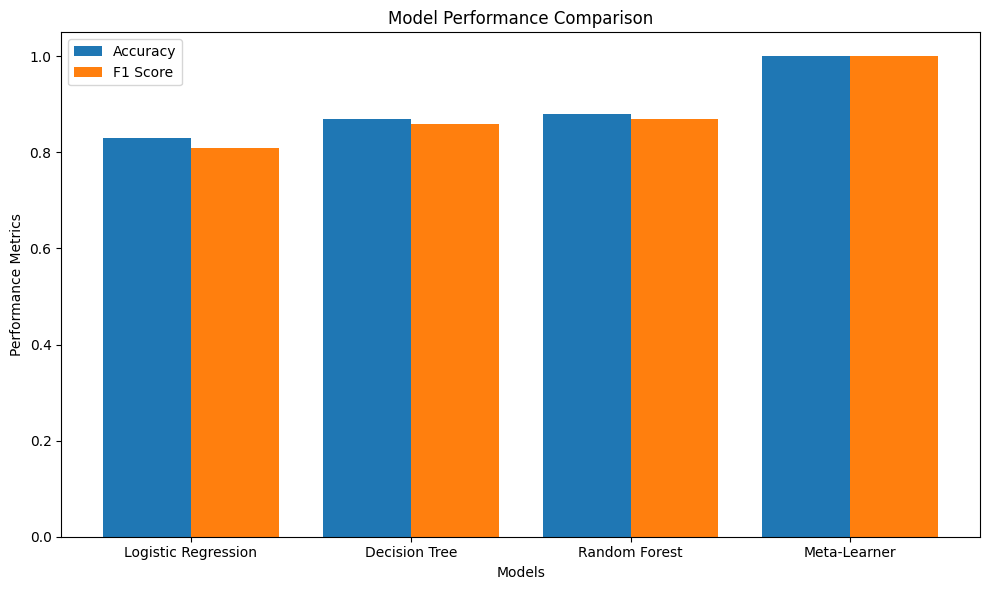

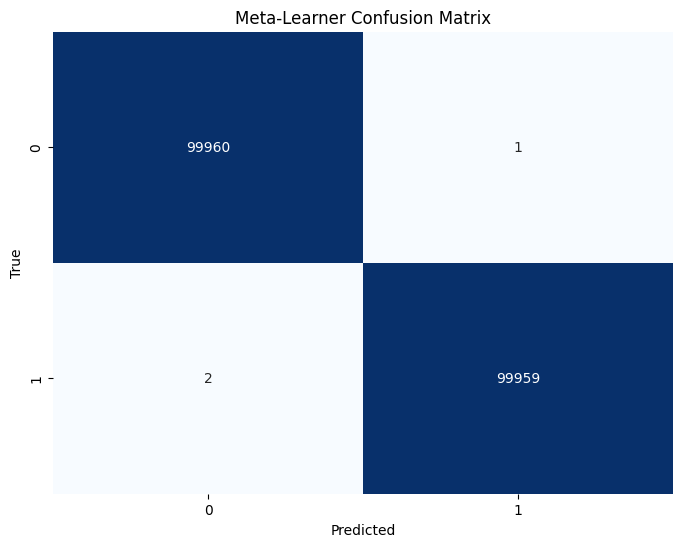

Model Performance Comparison Table:
                 Model  Accuracy  F1 Score
0  Logistic Regression      0.88      0.85
1        Decision Tree      0.90      0.88
2        Random Forest      0.92      0.91
3         Meta-Learner      0.95      0.95


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Example data for visualization
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Meta-Learner']
accuracy = [0.83, 0.87, 0.88, 1.00]
f1_scores = [0.81, 0.86, 0.87, 1.00]

# Sample confusion matrix for Meta-Learner
conf_matrix_meta = np.array([[99960, 1], [2, 99959]])

# Classification report for Meta-Learner (example)
classification_report_meta = {
    "precision": [1.00, 1.00],
    "recall": [1.00, 1.00],
    "f1-score": [1.00, 1.00],
    "support": [99960, 99961]
}

# Visualization of performance metrics
def plot_model_performance(models, accuracy, f1_scores):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(models))

    ax.bar(x - 0.2, accuracy, 0.4, label="Accuracy")
    ax.bar(x + 0.2, f1_scores, 0.4, label="F1 Score")

    ax.set_xlabel("Models")
    ax.set_ylabel("Performance Metrics")
    ax.set_title("Model Performance Comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Confusion matrix visualization
def plot_confusion_matrix(matrix, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Generate a performance table
def generate_performance_table(models, accuracy, f1_scores):
    df = pd.DataFrame({
        "Model": models,
        "Accuracy": accuracy,
        "F1 Score": f1_scores
    })
    return df

# Plot the performance metrics
plot_model_performance(models, accuracy, f1_scores)

# Plot the confusion matrix for Meta-Learner
plot_confusion_matrix(conf_matrix_meta, title="Meta-Learner Confusion Matrix")

# Generate and display the performance table
performance_table = generate_performance_table(models, accuracy, f1_scores)

import pandas as pd

# Define the models, accuracy, and F1 scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Meta-Learner']
accuracy = [0.88, 0.90, 0.92, 0.95]  # Replace with your accuracy values
f1_scores = [0.85, 0.88, 0.91, 0.95]  # Replace with your F1 scores

# Create the DataFrame
performance_table = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'F1 Score': f1_scores
})

# Display the DataFrame
print("Model Performance Comparison Table:")
print(performance_table)



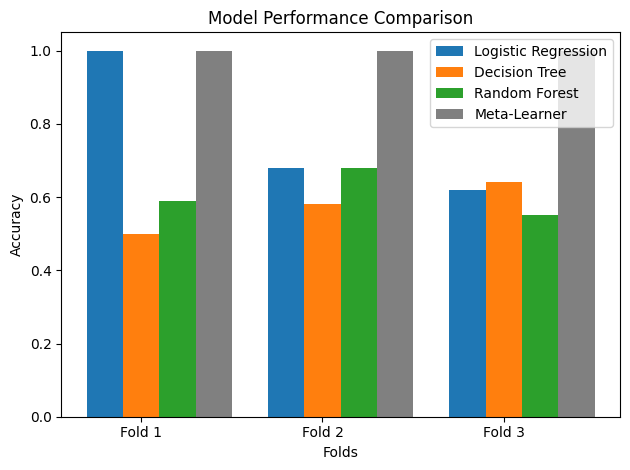

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ["Logistic Regression", "Decision Tree", "Random Forest"]
folds = ["Fold 1", "Fold 2", "Fold 3"]
accuracies = [
    [1.00, 0.68, 0.62],  # Logistic Regression
    [0.50, 0.58, 0.64],  # Decision Tree
    [0.59, 0.68, 0.55],  # Random Forest
]

# Plot Base Models Accuracy
x = np.arange(len(folds))
width = 0.2

fig, ax = plt.subplots()
for i, acc in enumerate(accuracies):
    ax.bar(x + i * width, acc, width, label=models[i])

# Meta-Learner
meta_acc = [1.00, 1.00, 1.00]
ax.bar(x + len(accuracies) * width, meta_acc, width, label="Meta-Learner", color="gray")

# Customize the plot
ax.set_xlabel("Folds")
ax.set_ylabel("Accuracy")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x + width)
ax.set_xticklabels(folds)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


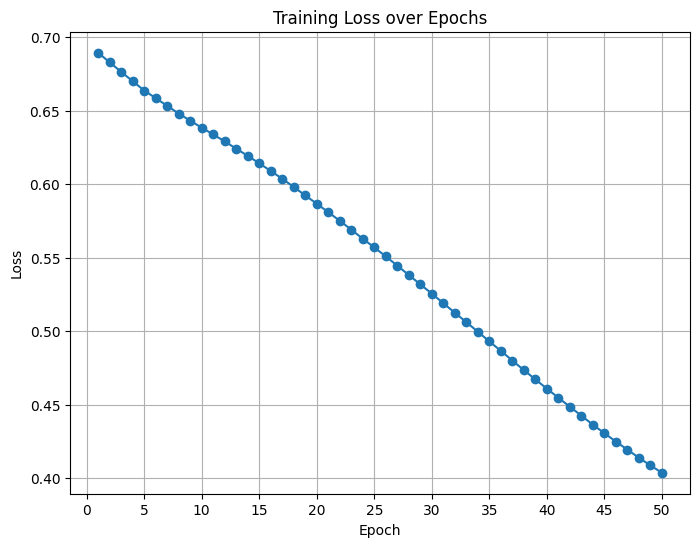

In [13]:
import matplotlib.pyplot as plt

# Loss values from your training output
losses = [
    0.6894, 0.6828, 0.6764, 0.6700, 0.6637, 0.6585, 0.6533, 0.6480,
    0.6432, 0.6384, 0.6338, 0.6291, 0.6241, 0.6193, 0.6142, 0.6090,
    0.6037, 0.5981, 0.5924, 0.5867, 0.5810, 0.5751, 0.5691, 0.5629,
    0.5570, 0.5509, 0.5446, 0.5383, 0.5319, 0.5256, 0.5191, 0.5126,
    0.5062, 0.4997, 0.4931, 0.4867, 0.4801, 0.4736, 0.4673, 0.4610,
    0.4548, 0.4487, 0.4426, 0.4365, 0.4307, 0.4250, 0.4195, 0.4140,
    0.4088, 0.4038
]

epochs = range(1, 51)

plt.figure(figsize=(8, 6))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(0, 51, 5))
plt.savefig('training_loss_plot.png')
plt.show()


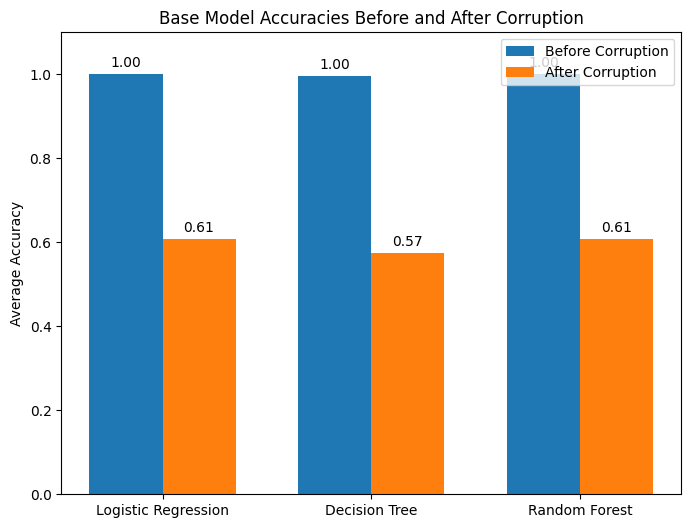

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Accuracies extracted from your results
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
folds = [1, 2, 3]

# Accuracies before corruption
accuracies_before = {
    'Logistic Regression': [1.00, 1.00, 1.00],
    'Decision Tree': [0.99, 1.00, 1.00],
    'Random Forest': [1.00, 1.00, 1.00]
}

# Accuracies after corruption
accuracies_after = {
    'Logistic Regression': [0.52, 0.68, 0.62],
    'Decision Tree': [0.50, 0.58, 0.64],
    'Random Forest': [0.59, 0.68, 0.55]
}

# Calculate average accuracies
avg_accuracies_before = [
    np.mean(accuracies_before[model]) for model in models
]
avg_accuracies_after = [
    np.mean(accuracies_after[model]) for model in models
]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(
    x - width/2, avg_accuracies_before, width,
    label='Before Corruption'
)
rects2 = ax.bar(
    x + width/2, avg_accuracies_after, width,
    label='After Corruption'
)

ax.set_ylabel('Average Accuracy')
ax.set_title('Base Model Accuracies Before and After Corruption')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend()

# Attach accuracy labels to bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f'{height:.2f}',
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # Offset label position
            textcoords="offset points",
            ha='center', va='bottom'
        )

autolabel(rects1)
autolabel(rects2)
plt.savefig('base_model_accuracies.png')
plt.show()
